# FDP Analysis with PrivacyGuard

## Introduction

This tutorial demonstrates how to use the FDP (f-Differential Privacy) Analysis feature in PrivacyGuard. The FDP analysis is based on the method described in "Auditing f-Differential Privacy in One Run" (https://arxiv.org/abs/2410.22235).

### What We'll Cover

In this tutorial, we will:
1. Set up synthetic attack results similar to what you'd get from MIA attacks
2. Use the `FDPAnalysisNode` to compute privacy parameters
3. Demonstrate the `compute_abstain_attack_fdp` function for comprehensive analysis
4. Interpret the results and understand privacy implications

Let's get started!

In [ ]:
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from privacy_guard.analysis.mia.fdp_analysis_node import FDPAnalysisNode, FDPAnalysisNodeOutput

# Set random seeds for reproducibility
np.random.seed(42)

## Synthetic Attack Results

For this tutorial, we'll create synthetic attack results that simulate what you would get from running a membership inference attack. In a real scenario, these would come from your actual attack implementation.

In [ ]:
# Simulate attack results - these would normally come from your MIA attack
# Let's create some realistic score distributions

# Number of training and test samples
n_train = 1000
n_test = 1000

# Simulate train scores (members) - typically higher scores
train_scores: NDArray = np.random.normal(loc=0.8, scale=0.3, size=n_train)

# Simulate test scores (non-members) - typically lower scores
test_scores: NDArray = np.random.normal(loc=0.3, scale=0.3, size=n_test)

# Combine scores and create labels
scores: NDArray = np.concatenate((train_scores, test_scores))
labels: NDArray = np.concatenate(
    (np.ones_like(train_scores), np.zeros_like(test_scores))
)

print(f"Total samples: {len(scores)}")
print(f"Members (training): {np.sum(labels == 1)}")
print(f"Non-members (test): {np.sum(labels == 0)}")

Total samples: 2000
Members (training): 1000
Non-members (test): 1000


Let's visualize the distribution of scores for members vs non-members:

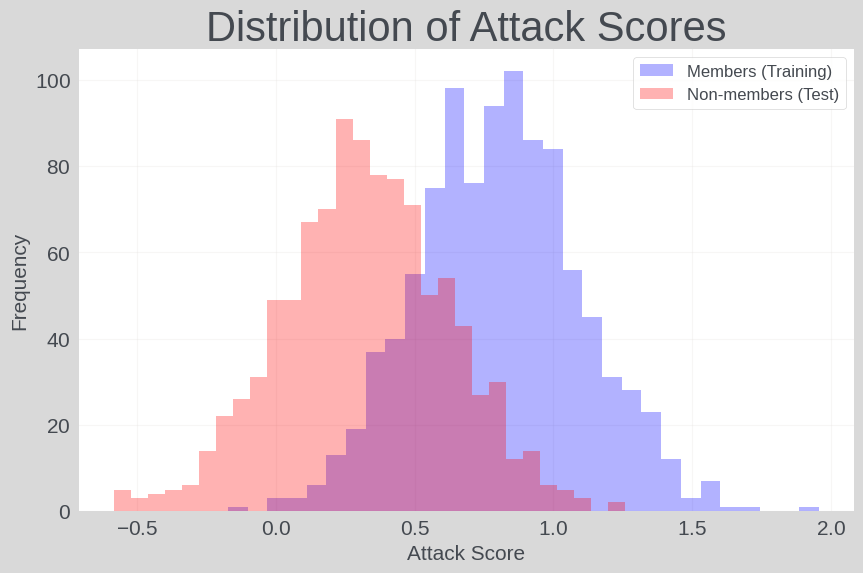

Member scores - Mean: 0.806, Std: 0.294
Non-member scores - Mean: 0.321, Std: 0.299


In [ ]:
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(train_scores, bins=30, alpha=0.3, label="Members (Training)", color="blue")
plt.hist(test_scores, bins=30, alpha=0.3, label="Non-members (Test)", color="red")

plt.xlabel("Attack Score")
plt.ylabel("Frequency")
plt.title("Distribution of Attack Scores")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(
    f"Member scores - Mean: {np.mean(train_scores):.3f}, Std: {np.std(train_scores):.3f}"
)
print(
    f"Non-member scores - Mean: {np.mean(test_scores):.3f}, Std: {np.std(test_scores):.3f}"
)

## Understanding FDP Analysis

The FDP (f-Differential Privacy) analysis helps us understand how much privacy information leaks through membership inference attacks. The key insight is that we can estimate the privacy parameters (epsilon) based on the attack's performance.

### Key Parameters:
- `m`: Total number of samples
- `c`: Number of correct predictions by the attacker
- `c_cap`: Total number of guesses made by the attacker

Let's see a basic example:

In [ ]:
# Basic FDP analysis example
m = 100  # Total number of samples
c = 70  # Number of correct predictions
c_cap = 80  # Total number of guesses

# Create FDP analysis node
fdp_node = FDPAnalysisNode(m=m, c=c, c_cap=c_cap)

# Run analysis
fdp_result: FDPAnalysisNodeOutput = fdp_node.run_analysis()

print("Privacy Analysis Results:")
print(f"Epsilon: {fdp_result.eps:.4f}")

Privacy Analysis Results:
Epsilon: 3.2906


## Comprehensive FDP Analysis Function

Now let's implement a comprehensive function that analyzes attack results across different parameter combinations:

In [ ]:
def compute_abstain_attack_fdp(
    mia_scores: NDArray,
    membership_labels: NDArray,
    step_size: int = 10,
    delta: float = 0,
    p_value: float = 0.05,
) -> Dict[str, Any]:
    """
    Compute FDP analysis for different numbers of guesses in a membership inference attack.

    Args:
        mia_scores (np.array): MIA score computed by the attack.
        membership_labels (np.array): Membership of samples in the training set of target model.
        delta (float): DP parameter for tolerance. Should be between 0 and 1.
        step_size (int): Step size for the grid search in number of guesses.
        p_value (float): Confidence of the statistical test. Should be between 0 and 1.

    Returns:
        dict: Dictionary of fdp-analysis for different number of guesses.
    """
    sorted_idx = np.argsort(mia_scores)[::-1]  # Sort in descending order
    target_memberships = membership_labels[sorted_idx].astype(int)

    # Create range of one-sided guesses (we'll double for total guesses)
    max_guesses = len(mia_scores) // 2
    one_side_guesses = np.logspace(1, np.log10(max_guesses), num=step_size, dtype=int)

    correct_guesses = []
    total_guesses = []

    for n_guesses in one_side_guesses:
        # Count correct predictions: top n_guesses should be members, bottom n_guesses should be non-members
        correct_top = np.sum(
            target_memberships[:n_guesses]
        )  # Members in top predictions
        correct_bottom = np.sum(
            1 - target_memberships[-n_guesses:]
        )  # Non-members in bottom predictions

        correct_guesses.append(correct_top + correct_bottom)
        total_guesses.append(2 * n_guesses)

    eps_list = []
    for correct_num, total_guess in zip(correct_guesses, total_guesses):
        fdp_node = FDPAnalysisNode(
            m=len(target_memberships), c=correct_num, c_cap=total_guess, delta=delta
        )
        result = fdp_node.run_analysis()
        eps_list.append(result.eps)

    # Find optimal configuration (highest epsilon)
    optimal_idx = np.argmax(eps_list)

    return {
        "eps": eps_list,
        "correct_num": correct_guesses,
        "total_guesses": total_guesses,
        "eps_opt": eps_list[optimal_idx],
        "guess_opt": one_side_guesses[optimal_idx],
        "correct_num_opt": correct_guesses[optimal_idx],
        "total_num": len(target_memberships),
        "delta": delta,
        "p_value": p_value,
    }


## Running the Comprehensive FDP Analysis

Now let's use our function to analyze the synthetic attack results:

In [ ]:
# Run the comprehensive FDP analysis
results: Dict[str, Any] = compute_abstain_attack_fdp(
    scores, labels, delta=1e-5, step_size=50, p_value=0.05
)

print("=== FDP Analysis Results ===")
print(f"Optimal Epsilon: {results['eps_opt']:.4f}")
print(f"Optimal one-sided guesses: {results['guess_opt']}")
print(f"Optimal correct predictions: {results['correct_num_opt']}")
print(f"Total samples: {results['total_num']}")
print(f"Delta parameter: {results['delta']}")

=== FDP Analysis Results ===
Optimal Epsilon: 5.3558
Optimal one-sided guesses: 126
Optimal correct predictions: 249
Total samples: 2000
Delta parameter: 1e-05


Let's visualize the epsilon values across different parameter combinations:

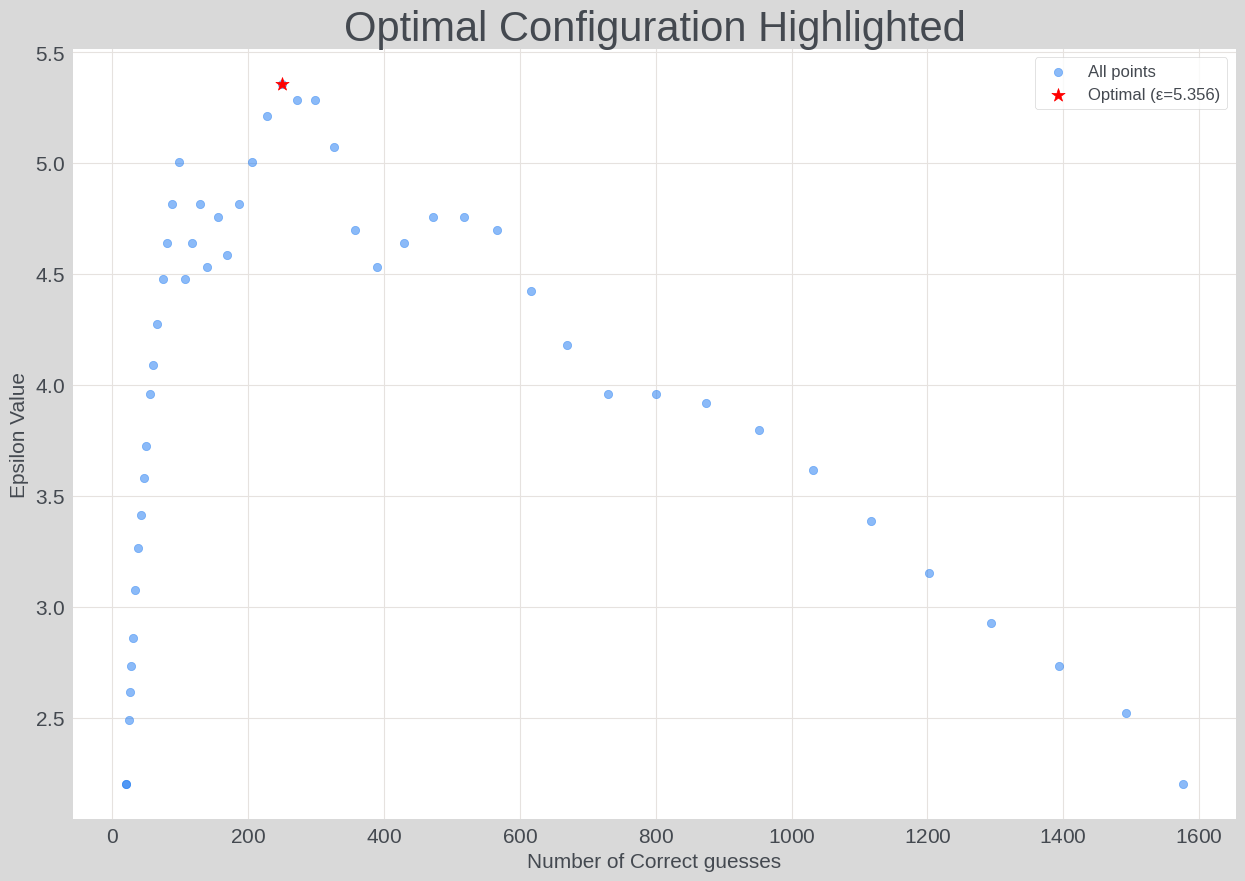

In [ ]:
plt.scatter(results["correct_num"], results["eps"], alpha=0.5, label="All points")
plt.scatter(
    results["correct_num_opt"],
    results["eps_opt"],
    color="red",
    s=100,
    marker="*",
    label=f'Optimal (ε={results["eps_opt"]:.3f})',
)
plt.xlabel("Number of Correct guesses")
plt.ylabel("Epsilon Value")
plt.title("Optimal Configuration Highlighted")
plt.legend()
plt.grid(True)
plt.show()

## Gaussian DP Auditing Example

Now let's implement a Gaussian DP auditing example using the FDPAnalysisNode. This demonstrates how to audit Gaussian differential privacy mechanisms.

In [ ]:
from numpy.random import normal
from scipy.stats import norm


# Gaussian DP Analysis Functions
def calculate_delta_gaussian(noise: float, epsilon: float) -> float:
    """Calculate delta for Gaussian DP given noise and epsilon."""
    delta = norm.cdf(-epsilon * noise + 1 / (2 * noise)) - np.exp(epsilon) * norm.cdf(
        -epsilon * noise - 1 / (2 * noise)
    )
    return delta


def calculate_epsilon_gaussian(noise: float, delta: float) -> float:
    """Calculate epsilon for Gaussian DP given noise and delta."""
    epsilon_upper = 100.0
    epsilon_lower = 0.0
    while epsilon_upper - epsilon_lower > 0.001:
        epsilon_middle = (epsilon_upper + epsilon_lower) / 2
        if calculate_delta_gaussian(noise, epsilon_middle) > delta:
            epsilon_lower = epsilon_middle
        else:
            epsilon_upper = epsilon_middle
    return epsilon_upper


# Set up Gaussian DP parameters
target_noise = 1.0
delta = 1e-5
actual_eps: float = calculate_epsilon_gaussian(noise=target_noise, delta=delta)

print(f"Theoretical privacy is: (Epsilon={actual_eps:.2f}, Delta={delta})")

# Generate synthetic canary data
total_canaries: int = 10**3
s_vector: NDArray = np.random.binomial(1, 0.5, size=total_canaries) * 2 - 1
noise_samples: NDArray = normal(0, target_noise, total_canaries)

noisy_s: NDArray = s_vector + noise_samples
sorted_noisy_s: NDArray = np.sort(noisy_s)

# Empirical privacy analysis for different number of guesses
eps_list_gaussian: List[float] = []
n_guesses_vec: NDArray = np.logspace(1, np.log10(total_canaries), num=50, dtype=int)

print("Running Gaussian DP empirical privacy analysis...")
for i, n_guesses in enumerate(n_guesses_vec):
    threshold_c = sorted_noisy_s[-int(n_guesses) // 2 + 1]
    correct_num = np.floor(
        n_guesses * (s_vector[noisy_s > threshold_c] == 1).mean()
    ).astype(int)

    fdp_node = FDPAnalysisNode(
        m=total_canaries,
        c=correct_num,
        c_cap=n_guesses,
        target_noise=target_noise,
        k=2,
        delta=delta,
    )
    result = fdp_node.run_analysis()
    eps_list_gaussian.append(result.eps)

    if i % 5 == 0:  # Print every 5th result
        print(
            f"n_guesses: {n_guesses}, correct: {correct_num}, empirical_eps: {result.eps:.4f}"
        )

eps_list_gaussian: NDArray = np.array(eps_list_gaussian)

Theoretical privacy is: (Epsilon=4.38, Delta=1e-05)
Running Gaussian DP empirical privacy analysis...
n_guesses: 10, correct: 10, empirical_eps: 1.2260
n_guesses: 15, correct: 15, empirical_eps: 1.8776
n_guesses: 25, correct: 25, empirical_eps: 2.7534
n_guesses: 40, correct: 40, empirical_eps: 3.6179
n_guesses: 65, correct: 65, empirical_eps: 4.3777
n_guesses: 104, correct: 104, empirical_eps: 4.3777
n_guesses: 167, correct: 167, empirical_eps: 4.3777
n_guesses: 268, correct: 255, empirical_eps: 4.1374
n_guesses: 429, correct: 404, empirical_eps: 4.1832
n_guesses: 686, correct: 621, empirical_eps: 3.6537


Let's visualize the Gaussian DP analysis results:

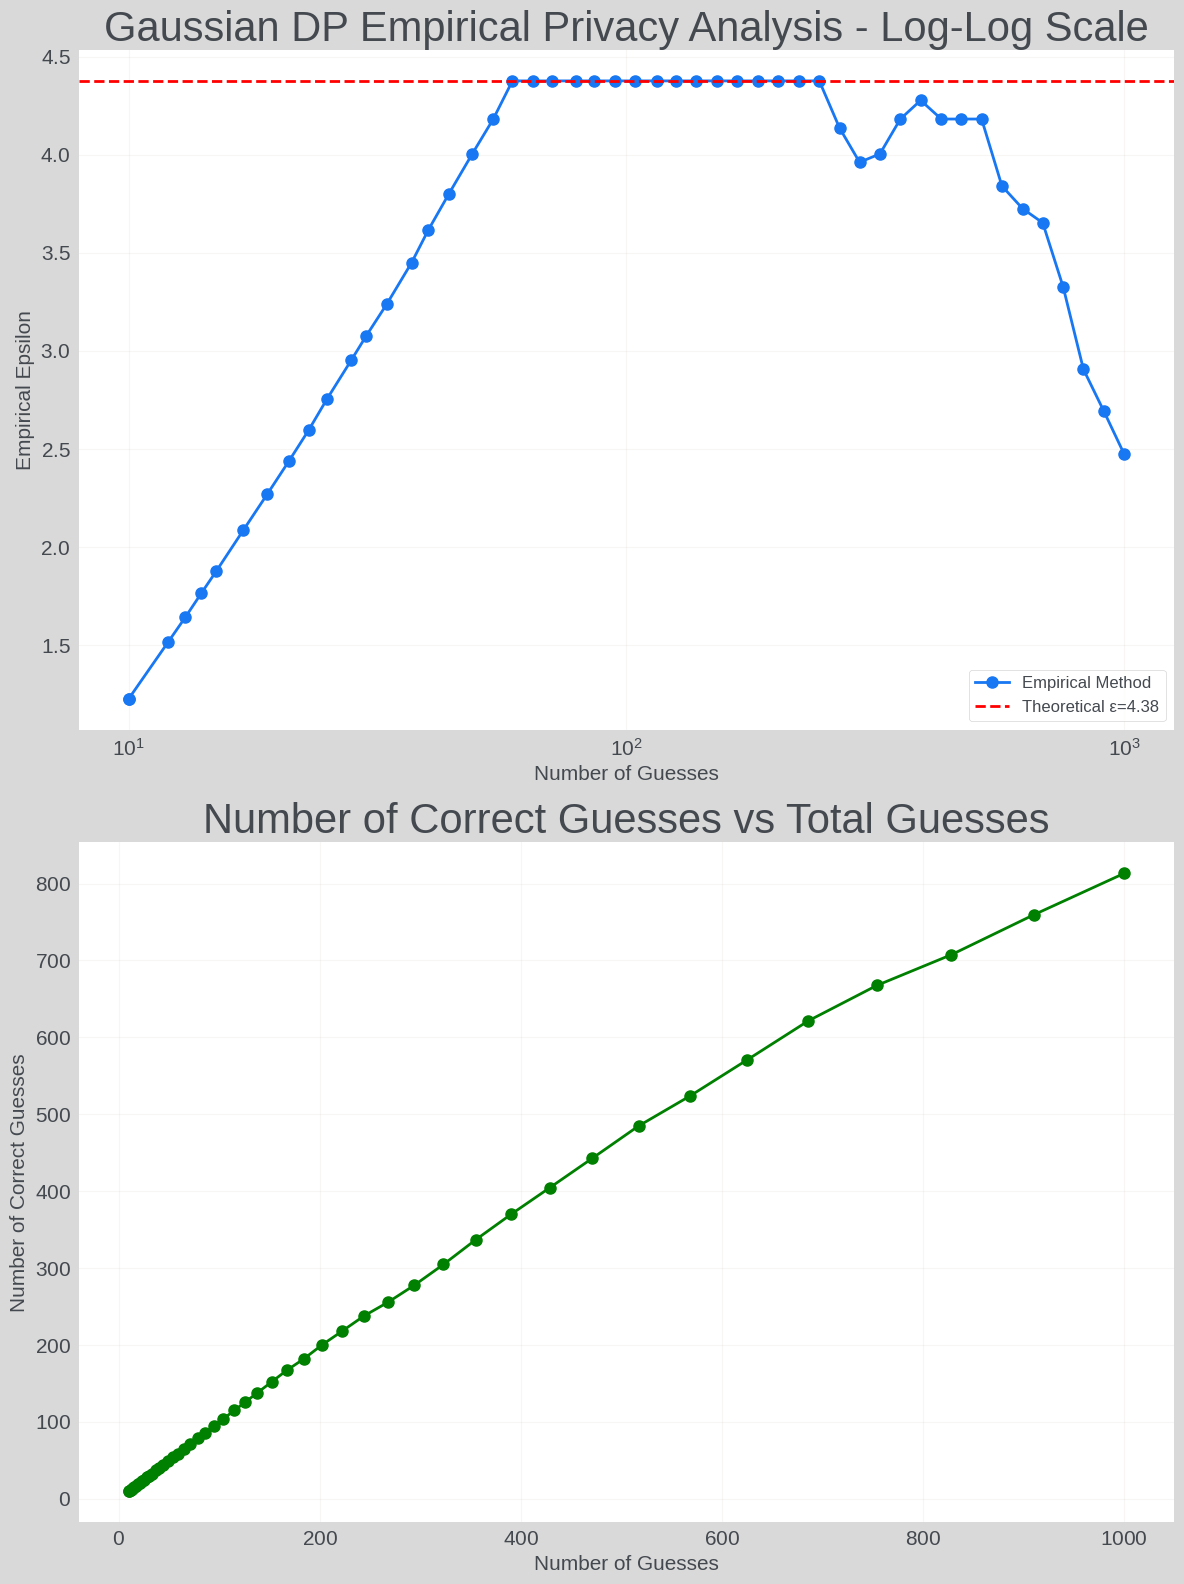

In [ ]:
# Plot Gaussian DP results
plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
plt.semilogx(
    n_guesses_vec,
    eps_list_gaussian,
    "o-",
    label="Empirical Method",
    markersize=8,
    linewidth=2,
)
plt.axhline(
    y=actual_eps,
    color="r",
    linestyle="--",
    label=f"Theoretical ε={actual_eps:.2f}",
    linewidth=2,
)
plt.xlabel("Number of Guesses")
plt.ylabel("Empirical Epsilon")
plt.title("Gaussian DP Empirical Privacy Analysis - Log-Log Scale")
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 1, 2)
correct_guesses: NDArray = np.array(
    [
        n_guesses
        * (s_vector[noisy_s > sorted_noisy_s[-int(n_guesses) // 2 + 1]] == 1).mean()
        for n_guesses in n_guesses_vec
    ]
)
plt.plot(n_guesses_vec, correct_guesses, "o-", markersize=8, linewidth=2, color="green")
plt.xlabel("Number of Guesses")
plt.ylabel("Number of Correct Guesses")
plt.title("Number of Correct Guesses vs Total Guesses")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This tutorial demonstrated how to use the FDP analysis functionality in PrivacyGuard for:

1. **Membership Inference Attack Analysis**: Computing privacy parameters based on attack performance
2. **Parameter Optimization**: Finding the optimal number of guesses to maximize privacy leakage detection
3. **Gaussian DP Auditing**: Empirical verification of theoretical privacy guarantees
4. **Visualization**: Understanding the relationship between attack parameters and privacy leakage

### Key Takeaways:

- **Higher epsilon values indicate more privacy leakage**
- **The optimal attack strategy balances correct predictions with total guesses**
- **Empirical privacy analysis can validate theoretical guarantees**
- **FDP analysis provides a principled way to measure privacy leakage**

### Next Steps:

For real-world applications, replace the synthetic data with actual attack results from your membership inference attacks. Consider experimenting with different values of delta and p_value to understand their impact on the analysis.